In [1]:
import collections
import operator
from auxiliary.ds import DataLoader
from auxiliary.logger import log

# from kaggle: The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. 
# The classification goal is to predict if the client will subscribe a term deposit (variable y).

_kaggle_path = "henriqueyamahata/bank-marketing"
raw_df = DataLoader.from_kaggle_path(_kaggle_path, sep=';').data
log(f'Dataset from "{_kaggle_path}":')
log(f"{raw_df.head()}")

2025-03-05 23:15:00,104 [INFO ] Dataset from "henriqueyamahata/bank-marketing":
2025-03-05 23:15:00,110 [INFO ]    age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...  

DataLoader(/home/err/.cache/kagglehub/datasets/henriqueyamahata/bank-marketing/versions/1/bank-additional-full.csv): reading data.


In [2]:
import operator
import pandas as pd
from functools import reduce
from homeworks.hw4.config import TARGET_VAR
from imblearn.over_sampling import RandomOverSampler

log(f'Statistics in "default" column: {raw_df["default"].value_counts()}')
raw_df.drop('default', axis=1, inplace=True)

columns_with_nan = ("job", "marital", "education", "housing", "loan")
log(f'Filtering out rows which have "unknown" value in any of the following columns: {columns_with_nan}')
log(f"Number of entries in dataframe before filtering: {len(raw_df)}")
df = raw_df[reduce(operator.and_, (raw_df[col] != 'unknown' for col in columns_with_nan))]
log(f"Number of entries in dataframe after filtering: {len(df)}")

log('Splitting into source and target')
X = df.drop(TARGET_VAR, axis=1)
y = df[TARGET_VAR]

log('Resampling')
log(f"Target var values-counts before resampling:\n {y.value_counts()}")
X, y = RandomOverSampler().fit_resample(X, y)
log(f"Target var values-counts after resampling:\n {y.value_counts()}")

2025-03-05 23:15:00,340 [INFO ] Statistics in "default" column: default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64
2025-03-05 23:15:00,345 [INFO ] Filtering out rows which have "unknown" value in any of the following columns: ('job', 'marital', 'education', 'housing', 'loan')
2025-03-05 23:15:00,346 [INFO ] Number of entries in dataframe before filtering: 41188
2025-03-05 23:15:00,360 [INFO ] Number of entries in dataframe after filtering: 38245
2025-03-05 23:15:00,361 [INFO ] Splitting into source and target
2025-03-05 23:15:00,366 [INFO ] Resampling
2025-03-05 23:15:00,369 [INFO ] Target var values-counts before resampling:
 y
no     33987
yes     4258
Name: count, dtype: int64
2025-03-05 23:15:00,479 [INFO ] Target var values-counts after resampling:
 y
no     33987
yes    33987
Name: count, dtype: int64


In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from auxiliary.ds import get_preprocessed_with_one_hot_enc, get_preprocessed_with_label_enc

log('Preprocessing, X with OHE, y with LE')
scaler = StandardScaler()
X = get_preprocessed_with_one_hot_enc(X)
X_arr = scaler.fit_transform(X)
X  = pd.DataFrame(X_arr, index=X.index, columns=X.columns)
y = get_preprocessed_with_label_enc(y)
log(f"After one-hot encoding, X has following columns: {X.columns}")
log(f"After label encoding, y has following values: {y.value_counts()}")
restored_df = pd.concat([pd.DataFrame({'wont_subscribe': y}), X], axis=1)

2025-03-05 23:15:00,484 [INFO ] Preprocessing, X with OHE, y with LE
2025-03-05 23:15:00,626 [INFO ] After one-hot encoding, X has following columns: Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr',
       'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_failure', '

{'no': np.int64(0), 'yes': np.int64(1)}


In [4]:
from homeworks.hw4.utils import get_variable_combinations, get_most_correlated_variables
from homeworks.hw4.config import FEATURES_COUNT

log('Creating a list of x-y correlations, where x is any column from X')
correlations_Xy = get_most_correlated_variables(X, y)[:FEATURES_COUNT]
cols, corrs = zip(*correlations_Xy)
new_combinations = get_variable_combinations(cols)

log('For these new combinations, let\'s add features to new dataframe features_df:')
log(f"Number of X columns before adding features: {len(X.columns)}")
features_df = pd.DataFrame({f'{col1}_X_{col2}': X[col1] * X[col2] for col1, col2 in new_combinations})
correlations_fy = get_most_correlated_variables(features_df, y)[:FEATURES_COUNT]

Xf = pd.concat((X, features_df), axis=1)

2025-03-05 23:15:00,648 [INFO ] Creating a list of x-y correlations, where x is any column from X
2025-03-05 23:15:00,682 [INFO ] 10 variables most correlated with target variable are:
2025-03-05 23:15:00,683 [INFO ]   poutcome_success: 0.29199788730296367
2025-03-05 23:15:00,683 [INFO ]   poutcome_nonexistent: -0.24473698689786874
2025-03-05 23:15:00,684 [INFO ]   contact_cellular: 0.24028886393193127
2025-03-05 23:15:00,684 [INFO ]   contact_telephone: -0.24028886393193127
2025-03-05 23:15:00,685 [INFO ]   month_may: -0.17840782822219023
2025-03-05 23:15:00,685 [INFO ]   month_oct: 0.15020991083286545
2025-03-05 23:15:00,686 [INFO ]   month_mar: 0.14442299486008942
2025-03-05 23:15:00,686 [INFO ]   month_sep: 0.13291591369399774
2025-03-05 23:15:00,687 [INFO ]   job_blue-collar: -0.12017223198731972
2025-03-05 23:15:00,687 [INFO ]   job_retired: 0.11863464683589196
2025-03-05 23:15:00,688 [INFO ] For these new combinations, let's add features to new dataframe features_df:
2025-03-05 

In [5]:
from sklearn.model_selection import train_test_split
from homeworks.hw4.config import TEST_RATIO

log('Making train/test splits')
X_train, X_test, Xf_train, Xf_test, y_train, y_test = train_test_split(X, Xf, y, test_size=TEST_RATIO, stratify=y)
for name in ('X_train', 'Xf_train', 'y_train', 'X_test', 'Xf_test', 'y_test'):
    log(f'{name} shape: {eval(name).shape}')

2025-03-05 23:15:00,920 [INFO ] Making train/test splits
2025-03-05 23:15:01,008 [INFO ] X_train shape: (54379, 45)
2025-03-05 23:15:01,009 [INFO ] Xf_train shape: (54379, 220)
2025-03-05 23:15:01,010 [INFO ] y_train shape: (54379,)
2025-03-05 23:15:01,010 [INFO ] X_test shape: (13595, 45)
2025-03-05 23:15:01,010 [INFO ] Xf_test shape: (13595, 220)
2025-03-05 23:15:01,011 [INFO ] y_test shape: (13595,)


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from homeworks.hw4.config import CLASSIFIERS_TO_TEST
from homeworks.hw4.utils import fit_with_grid_search

_cases = ('non-FE', 'FE')
map_grid_cv_results = {}
for clf_cls in CLASSIFIERS_TO_TEST:
    for case, source_train, source_test in (
        ('non-FE', X_train, X_test),
        ('FE', Xf_train, Xf_test),
    ):
        log(f'Training {clf_cls.__name__} classifier on {case} dataframe.')
        grid_search = fit_with_grid_search(clf_cls, source_train, y_train)
        log(f'Classifier results: {grid_search.cv_results_}')
        best_clf = grid_search.best_estimator_
        y_pred = best_clf.predict(source_test)
        accuracy = accuracy_score(y_test, y_pred)
        log(f'Score on test subset: {accuracy}')
        log(f'Classification report: \n{classification_report(y_test, y_pred)}')
        map_grid_cv_results.setdefault(clf_cls.__name__, {})[case] = {
            'search': grid_search,
            'best_clf': best_clf,
            'accuracy': accuracy,
        }


2025-03-05 23:15:01,017 [INFO ] Training AdaBoostClassifier classifier on non-FE dataframe.
2025-03-05 23:15:01,018 [INFO ] Doing grid search with AdaBoostClassifier and params: {'n_estimators': array([30, 50, 70], dtype=uint64), 'learning_rate': array([0.75, 1.  , 1.25])}
2025-03-05 23:15:39,513 [INFO ] Done in 38.495222772999114 s
2025-03-05 23:15:39,515 [INFO ] Classifier results: {'mean_fit_time': array([0.47022362, 0.73514509, 1.24605622, 0.59226174, 0.74812527,
       1.06557355, 0.53963962, 0.8020658 , 1.01969571]), 'std_fit_time': array([0.04558225, 0.0107474 , 0.14634354, 0.15082084, 0.00895433,
       0.02463183, 0.07017915, 0.12788225, 0.00608212]), 'mean_score_time': array([0.01510129, 0.02285471, 0.0301836 , 0.01465602, 0.02303009,
       0.03120074, 0.01521792, 0.0228466 , 0.03018527]), 'std_score_time': array([5.49706029e-04, 1.15666837e-04, 1.53932297e-03, 5.45236391e-04,
       2.23993685e-04, 1.16783584e-03, 3.84986835e-04, 6.09131428e-05,
       4.62033760e-04]), 'pa

2025-03-05 23:21:48,402 [INFO ] Visualization of results


<Axes: xlabel='model type', ylabel='accuracy'>

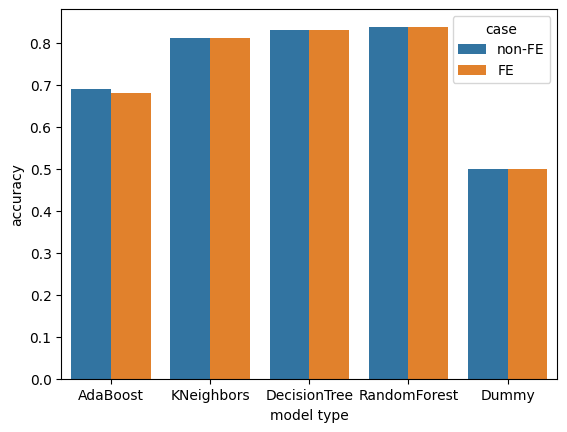

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

log('Visualization of results')
aux_df = pd.DataFrame([
    {'model type': cls_name.replace('Classifier', ''), 'case': case, 'accuracy': val[case]['accuracy']} 
    for cls_name, val in map_grid_cv_results.items() for case in _cases
])
sns.barplot(aux_df, x='model type', y='accuracy', hue='case')